# Time series forecasting

This notebook adapts the Tensorflow tutorial on [Time series forecasting](https://www.tensorflow.org/tutorials/structured_data/time_series) to data generated from a model for epidemic processes. 

## Things i changed

- 

## Steps

1. Imports and setup
2. Load and prepare the generated data
3. Baseline forecasting
4. Univariate LSTM based forecasting
5. Multivariate LSTM based forecasting - Single Step
6. Multivariate LSTM based forecasting - Multiple Steps

## Imports and setup

In [2]:
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

## Load and prepare the generated data

We load data from the ODE model introduced in the notebook "Probability and Information Theory". For each of the 150 virtuel outbreaks (randomized and with different model parameters), we have time series (with 500 steps) for four the variables "Susceptible", "Infected", "Recovered", and "Deceased".

In [3]:
csv_path = "./epidemic_process_raw_data.csv"
df = pd.read_csv(csv_path)
df.head()

,1,2,3,4,5,6,7,8,9,10,...,492,493,494,495,496,497,498,499,500,501
0,100.287149,103.541223,95.879814,96.354848,96.980932,97.855310,98.940537,100.187494,98.265709,95.307794,...,4.925236,4.922108,4.918981,4.915853,4.912726,4.950240,4.995291,5.040342,5.085393,5.130445
1,0.993774,1.017558,1.070030,1.116168,1.142078,1.134735,1.182418,1.272310,1.356565,1.438978,...,0.391775,0.384359,0.376942,0.369526,0.362109,0.356669,0.351595,0.346521,0.341447,0.336374
2,0.000000,0.017741,0.036585,0.054735,0.074266,0.096065,0.117691,0.139184,0.163615,0.189006,...,97.247764,96.062916,94.878068,93.693219,92.508371,92.617122,92.965783,93.314443,93.663103,94.011764
3,0.000000,0.000178,0.000364,0.000562,0.000757,0.000947,0.001160,0.001389,0.001635,0.001887,...,0.947347,0.950713,0.954079,0.957445,0.960811,0.959320,0.956929,0.954537,0.952146,0.949755
4,103.489688,100.282780,96.634270,98.532514,99.089272,97.440900,98.416534,101.404903,100.480758,98.277282,...,2.071958,2.064501,2.072213,2.090890,2.109567,2.128244,2.146921,2.165597,2.184274,2.202951


In [4]:
dfSusceptible = df[df.index % 4 == 0]
dfSusceptible.head()

,1,2,3,4,5,6,7,8,9,10,...,492,493,494,495,496,497,498,499,500,501
0,100.287149,103.541223,95.879814,96.354848,96.980932,97.855310,98.940537,100.187494,98.265709,95.307794,...,4.925236,4.922108,4.918981,4.915853,4.912726,4.950240,4.995291,5.040342,5.085393,5.130445
4,103.489688,100.282780,96.634270,98.532514,99.089272,97.440900,98.416534,101.404903,100.480758,98.277282,...,2.071958,2.064501,2.072213,2.090890,2.109567,2.128244,2.146921,2.165597,2.184274,2.202951
8,101.527421,97.711732,96.168179,95.677962,95.575326,96.109792,96.943831,98.007655,98.132798,97.951008,...,48.629414,48.662862,48.696309,48.729757,48.763204,48.796652,48.830099,48.863547,48.896994,48.930442
12,101.061107,99.112815,106.651686,101.622904,97.726686,95.692173,97.438263,102.084252,101.831030,99.975843,...,3.890526,3.869629,3.894123,3.928628,3.963133,3.997638,4.032143,4.066648,4.101153,4.135658
16,101.957189,101.898022,100.881113,99.892000,98.939878,98.048565,98.220024,99.206678,99.067041,98.559123,...,5.878943,5.910111,5.941279,5.959441,5.860292,5.761142,5.667567,5.680109,5.692651,5.705193


In [5]:
dfInfected = df[df.index % 4 == 1]
dfInfected.head()

,1,2,3,4,5,6,7,8,9,10,...,492,493,494,495,496,497,498,499,500,501
1,0.993774,1.017558,1.070030,1.116168,1.142078,1.134735,1.182418,1.272310,1.356565,1.438978,...,0.391775,0.384359,0.376942,0.369526,0.362109,0.356669,0.351595,0.346521,0.341447,0.336374
5,1.021677,1.045410,1.120324,1.175914,1.236878,1.306676,1.387931,1.477973,1.549873,1.615840,...,0.172933,0.171653,0.169739,0.167366,0.164993,0.162620,0.160247,0.157874,0.155501,0.153128
9,1.020043,1.011238,1.031122,1.048642,1.049479,1.022891,1.035862,1.079177,1.114531,1.147282,...,5.658505,5.625406,5.592308,5.559209,5.526111,5.493012,5.459914,5.426815,5.393717,5.360619
13,1.035248,1.014189,1.133178,1.135622,1.157984,1.213088,1.281406,1.359858,1.423234,1.481680,...,0.297238,0.292756,0.288433,0.284145,0.279857,0.275569,0.271280,0.266992,0.262704,0.258416
17,1.012666,1.016949,1.053194,1.097599,1.143640,1.192369,1.238880,1.283688,1.324305,1.363552,...,0.475822,0.467301,0.458779,0.450518,0.444609,0.438701,0.432715,0.425247,0.417780,0.410313


In [6]:
dfRecovered = df[df.index % 4 == 2]
dfRecovered.head()

,1,2,3,4,5,6,7,8,9,10,...,492,493,494,495,496,497,498,499,500,501
2,0.0,0.017741,0.036585,0.054735,0.074266,0.096065,0.117691,0.139184,0.163615,0.189006,...,97.247764,96.062916,94.878068,93.693219,92.508371,92.617122,92.965783,93.314443,93.663103,94.011764
6,0.0,0.017909,0.035748,0.056118,0.076620,0.097338,0.119592,0.143024,0.171253,0.201050,...,96.481711,97.126839,97.050590,96.452872,95.855153,95.257435,94.659716,94.061998,93.464279,92.866561
10,0.0,0.016990,0.034644,0.052866,0.071444,0.090609,0.108733,0.126058,0.142408,0.158437,...,45.237808,45.424013,45.610219,45.796424,45.982629,46.168835,46.355040,46.541246,46.727451,46.913657
14,0.0,0.017002,0.036315,0.057484,0.078381,0.098831,0.119563,0.140509,0.166486,0.194109,...,92.875601,92.371850,92.874094,93.598211,94.322327,95.046444,95.770560,96.494677,97.218794,97.942910
18,0.0,0.017589,0.037434,0.056572,0.076275,0.096907,0.116533,0.135387,0.157592,0.180893,...,93.437562,93.064191,92.690821,92.516054,94.132580,95.749106,97.237129,96.278611,95.320093,94.361575


In [7]:
dfDead = df[df.index % 4 == 3]
dfDead.head()

,1,2,3,4,5,6,7,8,9,10,...,492,493,494,495,496,497,498,499,500,501
3,0.0,0.000178,0.000364,0.000562,0.000757,0.000947,0.001160,0.001389,0.001635,0.001887,...,0.947347,0.950713,0.954079,0.957445,0.960811,0.959320,0.956929,0.954537,0.952146,0.949755
7,0.0,0.000175,0.000351,0.000558,0.000763,0.000968,0.001196,0.001443,0.001719,0.002004,...,0.989016,0.987952,0.986532,0.984855,0.983178,0.981502,0.979825,0.978148,0.976471,0.974794
11,0.0,0.000171,0.000352,0.000538,0.000729,0.000927,0.001126,0.001324,0.001488,0.001642,...,0.454590,0.455255,0.455920,0.456585,0.457250,0.457914,0.458579,0.459244,0.459909,0.460574
15,0.0,0.000181,0.000364,0.000563,0.000774,0.001003,0.001192,0.001351,0.001575,0.001822,...,0.951079,0.954145,0.954334,0.953888,0.953443,0.952997,0.952552,0.952106,0.951661,0.951215
19,0.0,0.000180,0.000358,0.000550,0.000740,0.000931,0.001138,0.001359,0.001574,0.001787,...,0.975329,0.959467,0.943605,0.929243,0.928406,0.927568,0.927127,0.934226,0.941326,0.948426


Below a plot of three infection time series for the three first outbreaks.

<Axes: >

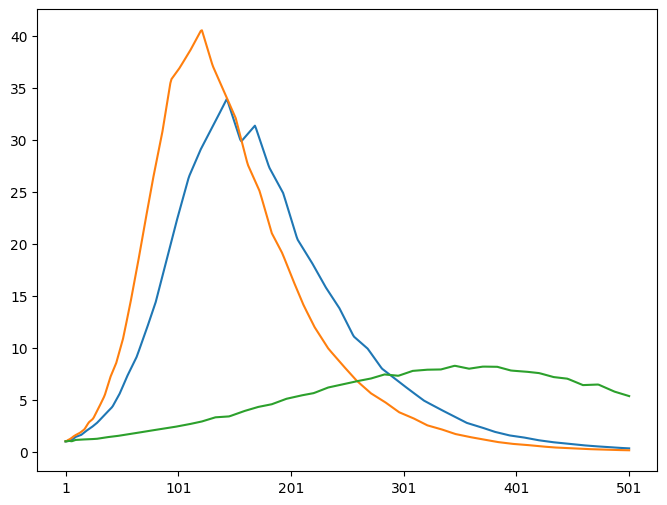

In [8]:
dfInfected.loc[1,:].plot()
dfInfected.loc[5,:].plot()
dfInfected.loc[9,:].plot()

We define a 90% / 10% of data for training / testing.

In [9]:
dfInfected_arr = dfInfected.values
dfInfected_arr.shape
TRAIN_SPLIT = int(dfInfected_arr.shape[0]-dfInfected_arr.shape[0]*0.1)
TRAIN_SPLIT

135

We standardize the data.

In [10]:
uni_train_mean = dfInfected_arr[:TRAIN_SPLIT].mean()
uni_train_std = dfInfected_arr[:TRAIN_SPLIT].std()
uni_data = (dfInfected_arr-uni_train_mean)/uni_train_std
print ('\n Univariate data shape')
print(uni_data.shape)


 Univariate data shape
(150, 501)


We split the data into time series of `univariate_past_history=20` days length and predict the future of the current day, i.e., `univariate_future_target=0`, for the "infected" variable. 

In [11]:
def univariate_data(dataset, start_series, end_series, history_size, target_size):
    data = []
    labels = []
    start_index = history_size
    end_index = len(dataset[0]) - target_size   
    for c in range(start_series, end_series):
        for i in range(start_index, end_index):
            indices = range(i-history_size, i)
            # Reshape data from (history_size,) to (history_size, 1)
            data.append(np.reshape(dataset[c][indices], (history_size, 1)))
            labels.append(dataset[c][i+target_size])
    return np.array(data), np.array(labels)

In [12]:
univariate_past_history = 20 #days
univariate_future_target = 0 #current day

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, len(uni_data),
                                       univariate_past_history,
                                       univariate_future_target)

In [13]:
print ('Single window of past history')
print (x_train_uni[0])
print ('\n Target number to predict')
print (y_train_uni[0])
print ('\n Number of traing data points')
print (y_train_uni.shape[0])
print ('\n Number of test data points')
print (x_val_uni.shape[0])

Single window of past history
[[-0.95291296]
 [-0.95044298]
 [-0.94499366]
 [-0.9402021 ]
 [-0.93751136]
 [-0.93827393]
 [-0.93332191]
 [-0.92398652]
 [-0.91523643]
 [-0.90667772]
 [-0.90243571]
 [-0.89846308]
 [-0.89449045]
 [-0.89051782]
 [-0.88593997]
 [-0.87701137]
 [-0.86808277]
 [-0.85915417]
 [-0.85022557]
 [-0.84167481]]

 Target number to predict
-0.8339932964893617

 Number of traing data points
64935

 Number of test data points
7215


In [14]:
def create_time_steps(length):
    return list(range(-length, 0))

In [15]:
def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0
    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10,label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future+5)*2])
    plt.xlabel('Time-Step')
    return plt

<module 'matplotlib.pyplot' from 'C:\\Users\\kemal\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python310\\site-packages\\matplotlib\\pyplot.py'>

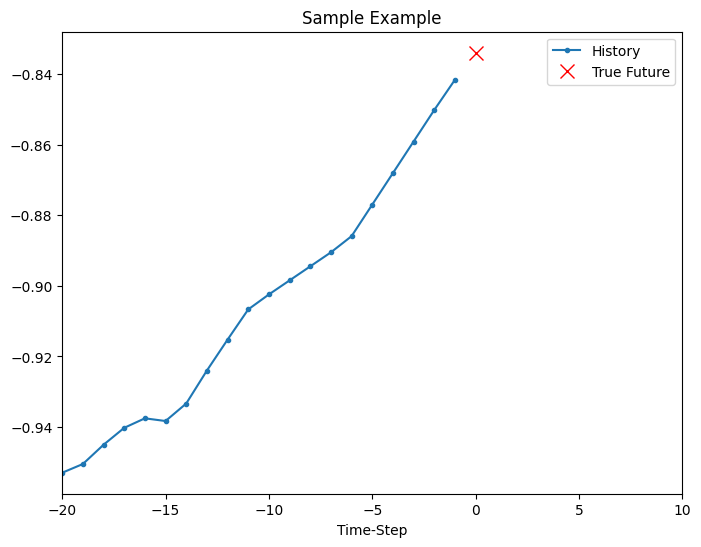

In [16]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

## Baseline forecasting

Predicts the mean of the `history`.

In [17]:
def baseline(history):
    return np.mean(history)

<module 'matplotlib.pyplot' from 'C:\\Users\\kemal\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python310\\site-packages\\matplotlib\\pyplot.py'>

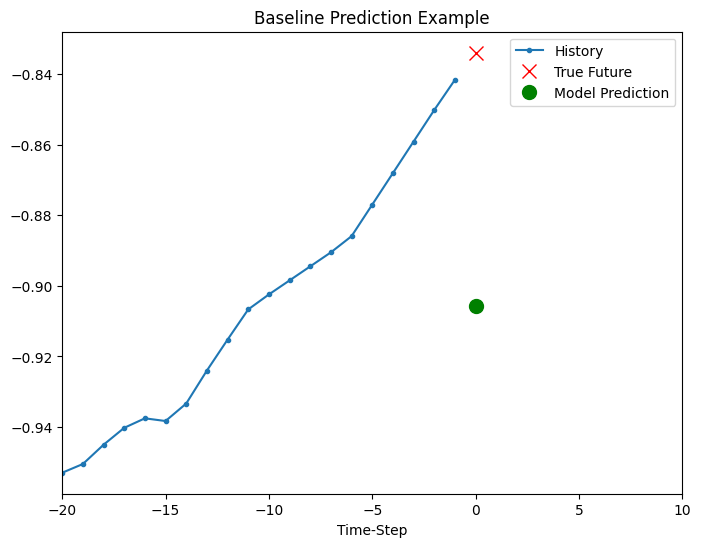

In [18]:
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0, 'Baseline Prediction Example')

## Univariate LSTM based forecasting

In [19]:
print (x_train_uni.shape)
print (y_train_uni.shape)
x_train_uni.dtype

(64935, 20, 1)
(64935,)


dtype('float64')

Batching and resampling; the dataset is repeated indefinitely. Check the tutorial for the details.

In [20]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

train_univariate

<_RepeatDataset element_spec=(TensorSpec(shape=(None, 20, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

We define the first LSTM model with 8 units.

In [21]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')
simple_lstm_model.summary()
x_train_uni.shape[-2:]

C:\Users\kemal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 8)              │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 329 (1.29 KB)

 Trainable params: 329 (1.29 KB)

 Non-trainable params: 0 (0.00 B)

(20, 1)

In [22]:
for x, y in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)
    print(y.shape)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step  
(256, 1)
(256,)


When passing an indefinitely repeated training data set, we need to specify the numbre of steps per training interval (epoch).

In [23]:
EVALUATION_INTERVAL = 2000
EPOCHS = 10

simple_lstm_model.fit(train_univariate, 
                      epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, 
                      validation_steps=50)

Epoch 1/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - loss: 0.1046 - val_loss: 0.0040
Epoch 2/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - loss: 0.0045 - val_loss: 0.0027
Epoch 3/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - loss: 0.0033 - val_loss: 0.0022
Epoch 4/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - loss: 0.0028 - val_loss: 0.0024
Epoch 5/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - loss: 0.0025 - val_loss: 0.0020
Epoch 6/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - loss: 0.0024 - val_loss: 0.0023
Epoch 7/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - loss: 0.0022 - val_loss: 0.0014
Epoch 8/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - loss: 0.0020 - val_loss: 0.0025
Epoch 9/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - loss: 0.0020 - val_loss: 0.0012
Epoch 10/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - loss: 0.0018 - val_loss: 0.0019


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


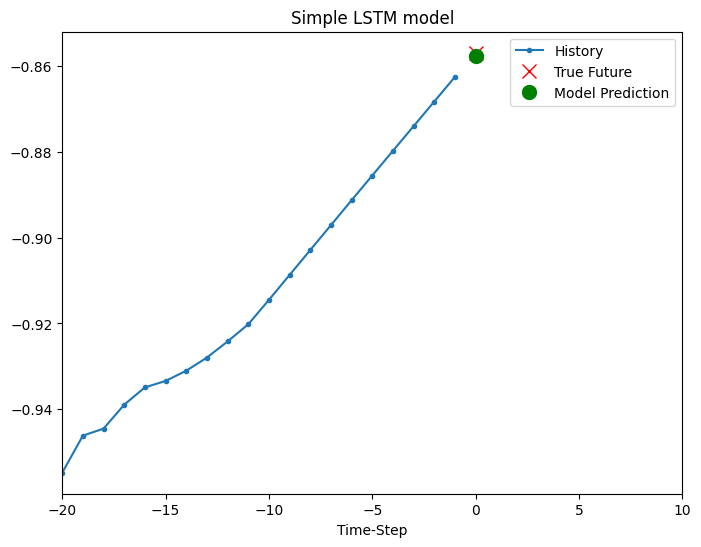

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


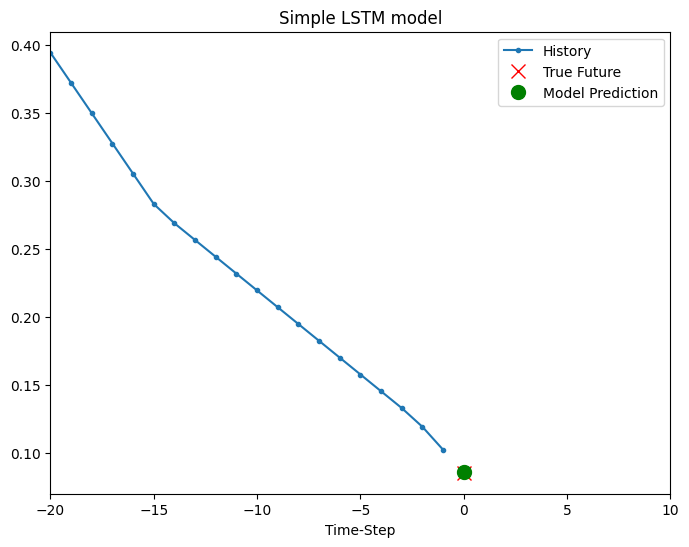

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


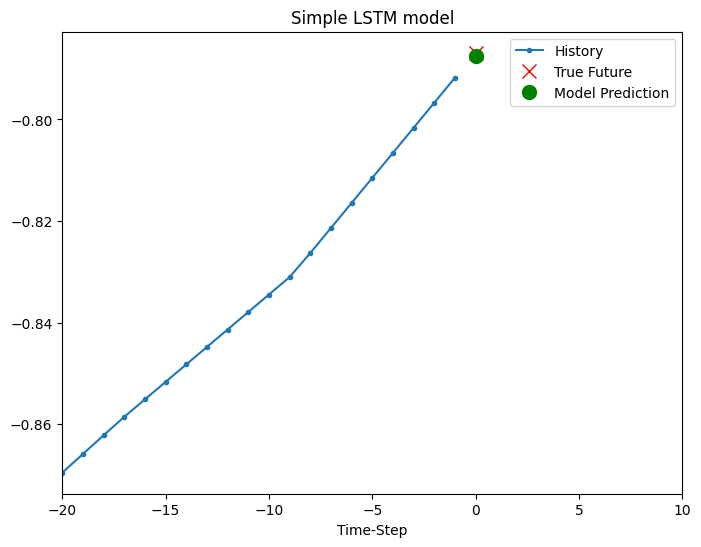

In [24]:
for x, y in val_univariate.take(3):
    plot = show_plot([x[0].numpy(), y[0].numpy(), simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
    plot.show()

## Multivariate LSTM based forecasting - Single Step

We use three variables "Infected", "Recovered", and "Deceased", to forcast "Infected" at one single day in the future.

Here a plot of the time series of the three variables for one outbreak. 

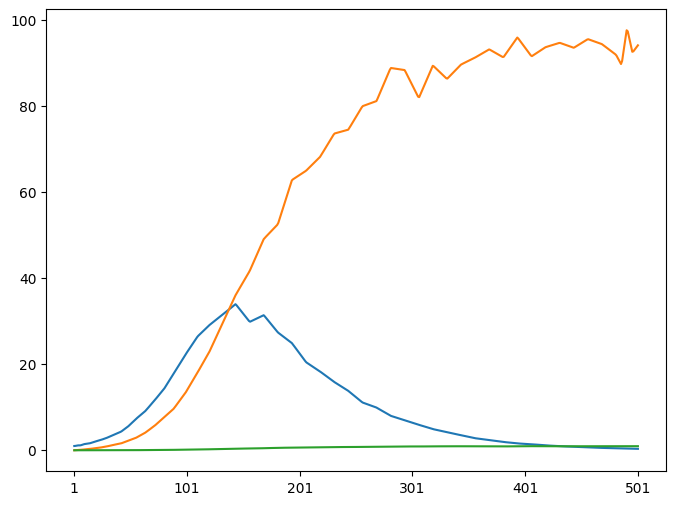

In [25]:
dfInfected.loc[1,:].plot()
dfRecovered.loc[2,:].plot()
dfDead.loc[3,:].plot()
dfInfected = dfInfected.values
dfRecovered_arr = dfRecovered.values
dfDead_arr = dfDead.values

We prepare the dataset.

In [26]:
#as before
dfInfected_train_mean = dfInfected_arr[:TRAIN_SPLIT].mean()
dfInfected_train_std = dfInfected_arr[:TRAIN_SPLIT].std()
dfInfected_data = (dfInfected_arr-dfInfected_train_mean)/dfInfected_train_std
#for Recovered
dfRecovered_train_mean = dfRecovered_arr[:TRAIN_SPLIT].mean()
dfRecovered_train_std = dfRecovered_arr[:TRAIN_SPLIT].std()
dfRecovered_data = (dfRecovered_arr-dfRecovered_train_mean)/dfRecovered_train_std
#for Dead
dfDead_train_mean = dfDead_arr[:TRAIN_SPLIT].mean()
dfDead_train_std = dfDead_arr[:TRAIN_SPLIT].std()
dfDead_data = (dfDead_arr-dfDead_train_mean)/dfDead_train_std

In [27]:
dataset = np.array([dfInfected_data, dfRecovered_data, dfDead_data])
dataset.shape
print ('\n Multivariate data shape')
print(dataset.shape)


 Multivariate data shape
(3, 150, 501)


In [28]:
def multivariate_data(dataset, target, start_series, end_series, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []
    start_index = history_size
    end_index = len(dataset[0][0]) - target_size   
    for c in range(start_series, end_series):
        for i in range(start_index, end_index):
            indices = range(i-history_size, i, step)
            one = dataset[0][c][indices]
            two = dataset[1][c][indices]
            three = dataset[2][c][indices]
            data.append(np.transpose(np.array([one, two, three])))
            
            if single_step:
                labels.append(target[c][i+target_size])
            else:
                labels.append(np.transpose(target[c][i:i+target_size]))
    return np.array(data), np.array(labels)

We get training and valdation data for time series with a `past_history = 20` days for every other day (`STEP = 2`) and want to predict the "Infected" five days ahead (`future_target = 5`).

In [29]:
past_history = 20
future_target = 5
STEP = 2

x_train_single, y_train_single = multivariate_data(dataset, dfInfected_data, 0, TRAIN_SPLIT, 
                                                   past_history, future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dfInfected_data, TRAIN_SPLIT, dataset.shape[1], 
                                               past_history, future_target, STEP,
                                               single_step=True)

In [30]:
print ('Single window of past history : {}'.format(x_train_single[0].shape))
print(dataset.shape)

Single window of past history : (10, 3)
(3, 150, 501)


As before, batching and resampling; the dataset is repeated indefinitely.

In [31]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [32]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32, input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')
single_step_model.summary()
x_train_single.shape[-2:]

C:\Users\kemal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 32)             │         4,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,641 (18.13 KB)

 Trainable params: 4,641 (18.13 KB)

 Non-trainable params: 0 (0.00 B)

(10, 3)

In [33]:
for x, y in val_data_single.take(1):
    print(single_step_model.predict(x).shape)
print ('\n Number of traing data points')
print (x_train_single.shape[0])
print ('\n Number of test data points')
print (x_val_single.shape[0])

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  
(256, 1)

 Number of traing data points
64260

 Number of test data points
7140


In [34]:
single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=50)

Epoch 1/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - loss: 0.0717 - val_loss: 0.0249
Epoch 2/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - loss: 0.0266 - val_loss: 0.0208
Epoch 3/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - loss: 0.0225 - val_loss: 0.0203
Epoch 4/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - loss: 0.0203 - val_loss: 0.0170
Epoch 5/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - loss: 0.0186 - val_loss: 0.0153
Epoch 6/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - loss: 0.0175 - val_loss: 0.0151
Epoch 7/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - loss: 0.0168 - val_loss: 0.0150
Epoch 8/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - loss: 0.0161 - val_loss: 0.0139
Epoch 9/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - loss: 0.0156 - val_loss: 0.0126
Epoch 10/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - loss: 0.0152 - val_loss: 0.0134


In [35]:
def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()
    plt.show()

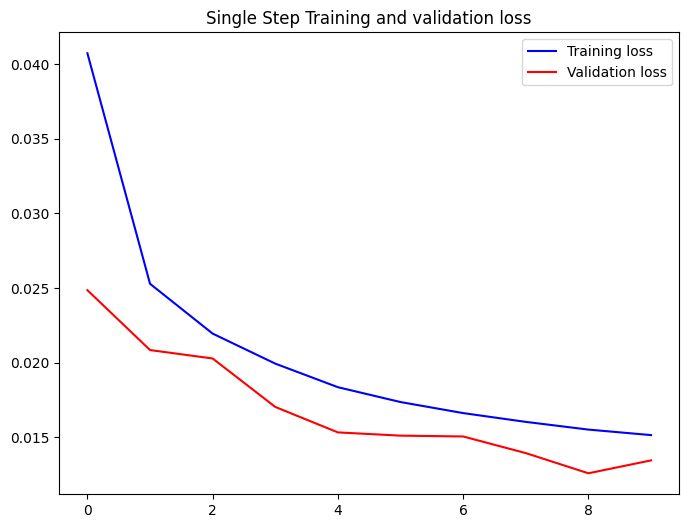

In [36]:
plot_train_history(single_step_history,'Single Step Training and validation loss')

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


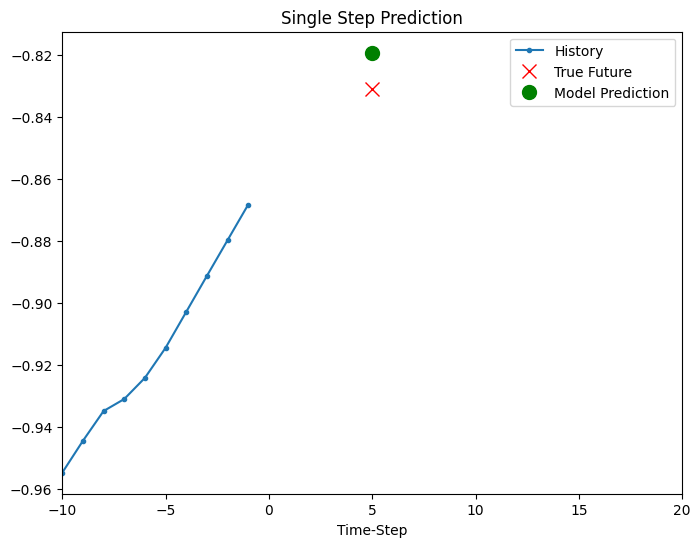

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


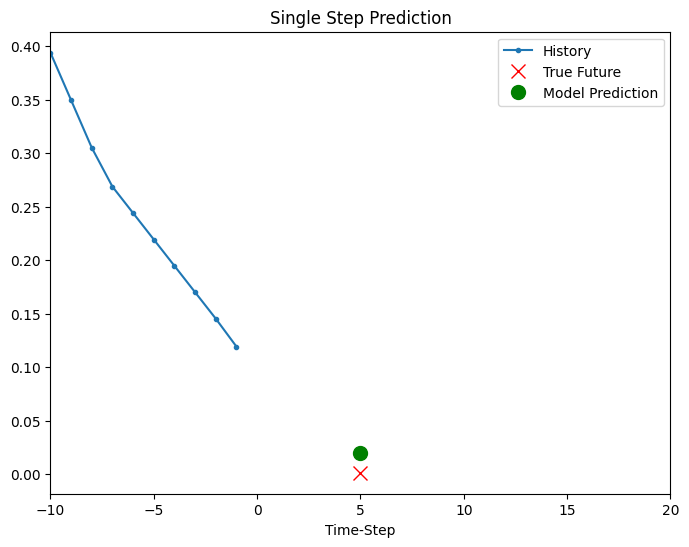

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


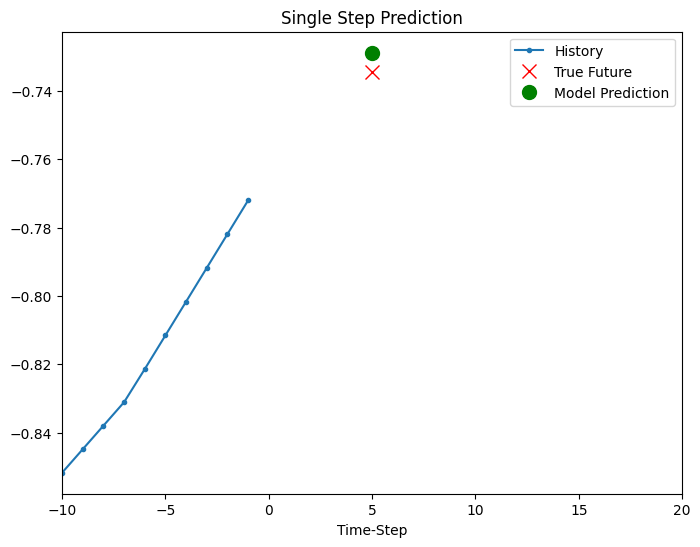

In [37]:
for x, y in val_data_single.take(3):
    plot = show_plot([x[0][:, 0].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], future_target,
                   'Single Step Prediction')
    plot.show()

## Multivariate LSTM - Multiple Steps

Still, we use a series of observed values of the three variables "Infected", "Recovered", and "Deceased" (`past_history = 40, STEP =2`), but now to forcast the "Infected" values for a series day in the future (`future_target = 10`).

In [59]:
past_history = 40
future_target = 10
STEP =2
x_train_multi, y_train_multi = multivariate_data(dataset, dfInfected_data, 0, TRAIN_SPLIT, 
                                                    past_history, future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dfInfected_data, TRAIN_SPLIT, dataset.shape[1], 
                                                past_history, future_target, STEP)

In [60]:
print ('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('\nTarget window to predict : {}'.format(y_train_multi[0].shape))
print ('\nNumber of traing data points: {}'.format(x_train_multi.shape[0]))
print ('\nNumber of test data points: {}'.format(x_val_multi.shape[0]))

Single window of past history : (20, 3)

Target window to predict : (10,)

Number of traing data points: 60885

Number of test data points: 6765


As before, batching and resampling; the dataset is repeated indefinitely.

In [61]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [62]:
def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(12, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)
    plt.plot(num_in, np.array(history[:, 0]), label='History')
    plt.plot(np.arange(num_out), np.array(true_future), 'bo', label='True Future')
    if prediction.any():
        plt.plot(np.arange(num_out), np.array(prediction), 'ro', label='Predicted Future')
    plt.legend(loc='upper left')
    plt.show()

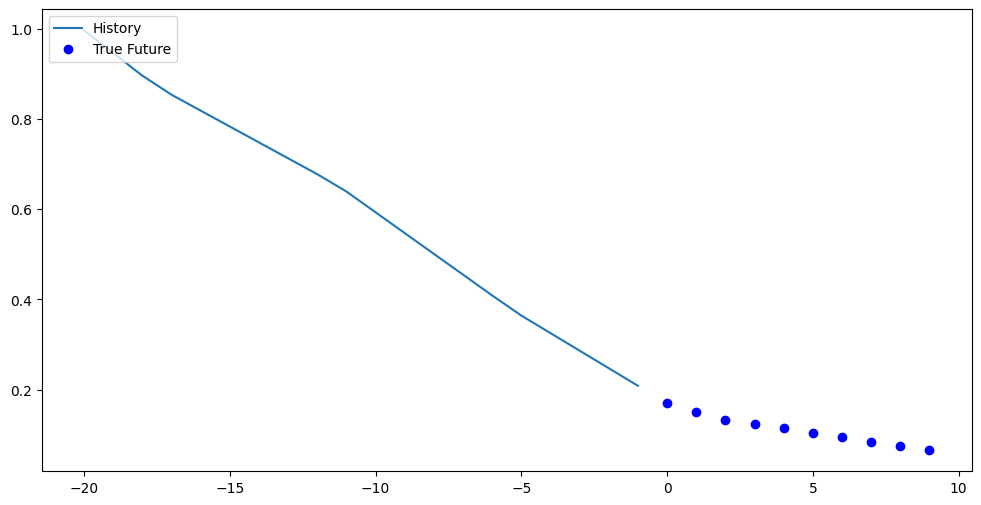

In [75]:
for x, y in train_data_multi.take(1):
    multi_step_plot(x[0], y[0], np.array([0]))

Now we bild a model with two LSTM layers.

In [43]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(future_target))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')
multi_step_model.summary()
x_train_multi.shape[-2:]

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 20, 32)         │         4,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,914 (30.91 KB)

 Trainable params: 7,914 (30.91 KB)

 Non-trainable params: 0 (0.00 B)

(20, 3)

In [44]:
for x, y in val_data_multi.take(1):
    print (multi_step_model.predict(x).shape)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step  
(256, 10)


The training time is longer for this more complex model.

In [45]:
multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

Epoch 1/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 37s 17ms/step - loss: 0.1522 - val_loss: 0.0346
Epoch 2/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 35s 17ms/step - loss: 0.0377 - val_loss: 0.0342
Epoch 3/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 34s 17ms/step - loss: 0.0302 - val_loss: 0.0315
Epoch 4/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 34s 17ms/step - loss: 0.0261 - val_loss: 0.0186
Epoch 5/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 34s 17ms/step - loss: 0.0231 - val_loss: 0.0200
Epoch 6/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 34s 17ms/step - loss: 0.0210 - val_loss: 0.0182
Epoch 7/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 34s 17ms/step - loss: 0.0195 - val_loss: 0.0204
Epoch 8/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 35s 18ms/step - loss: 0.0185 - val_loss: 0.0158
Epoch 9/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 35s 17ms/step - loss: 0.0177 - val_loss: 0.0183
Epoch 10/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 34s 17ms/step - loss: 0.0172 - val_loss: 0.0153


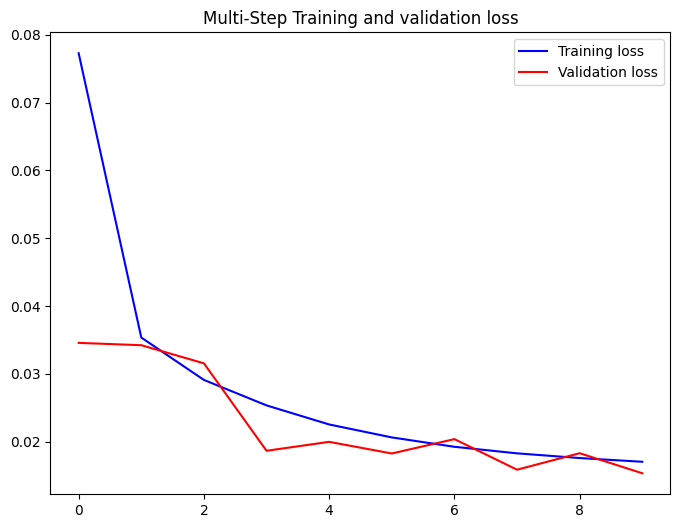

In [46]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


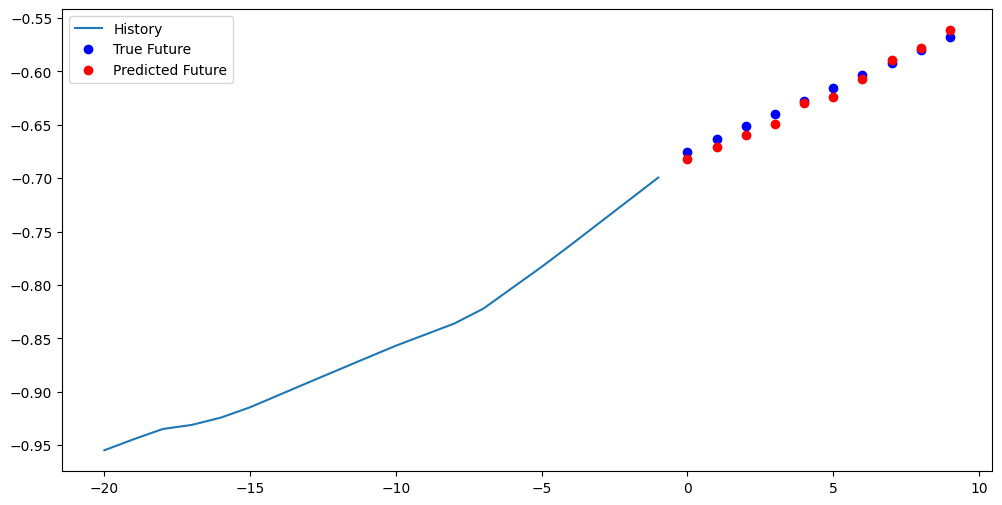

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


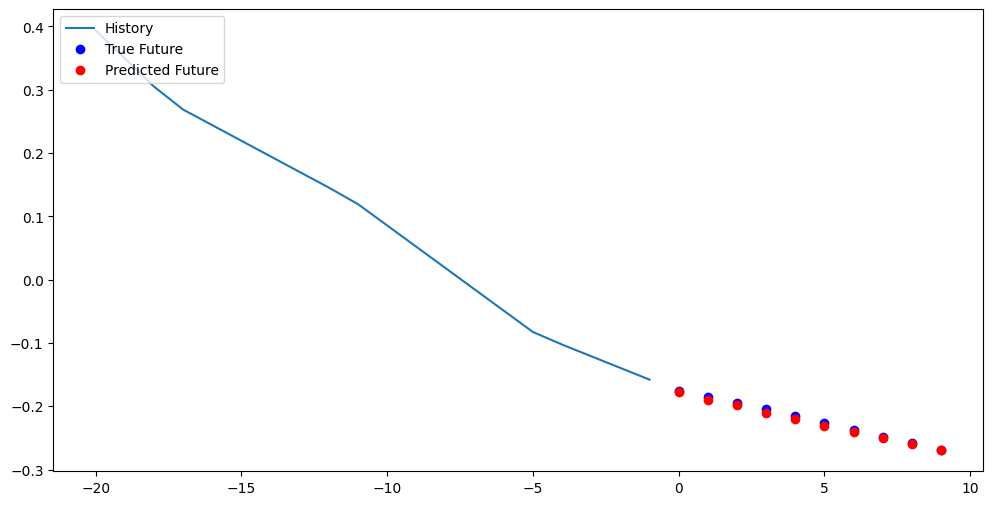

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


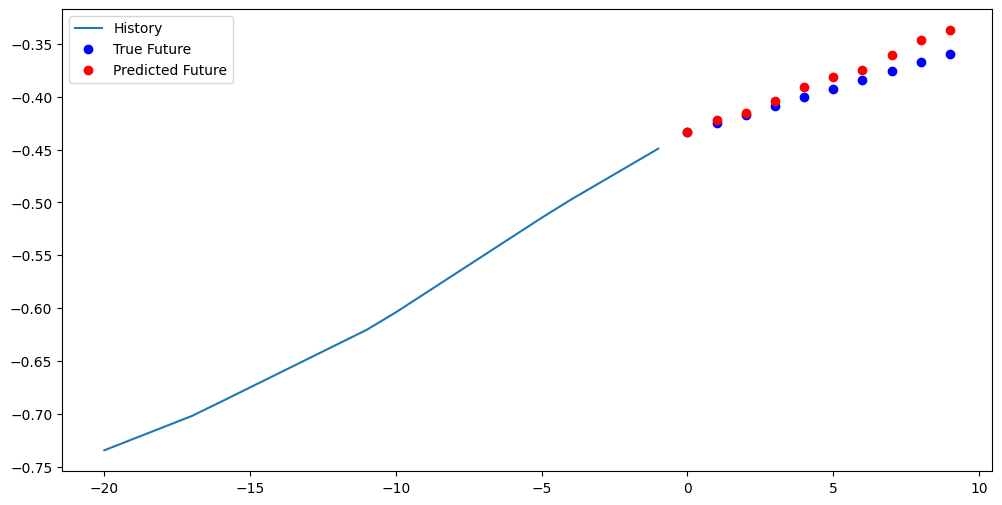

In [47]:
for x, y in val_data_multi.take(3):
    multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])

## MODIEFIED MODELS

- SWAPPING FROM LSTM TO GRU

### Univariate GRU based forecasting

(64935, 20, 1)
(64935,)


C:\Users\kemal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 8)              │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 273 (1.07 KB)

 Trainable params: 273 (1.07 KB)

 Non-trainable params: 0 (0.00 B)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step  
(256, 1)
(256,)
Epoch 1/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - loss: 0.0280 - val_loss: 0.0021
Epoch 2/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - loss: 0.0026 - val_loss: 0.0017
Epoch 3/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - loss: 0.0020 - val_loss: 0.0015
Epoch 4/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - loss: 0.0018 - val_loss: 0.0023
Epoch 5/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - loss: 0.0019 - val_loss: 0.0016
Epoch 6/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 7/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - loss: 0.0018 - val_loss: 0.0013
Epoch 8/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - loss: 0.0016 - val_loss: 7.7563e-04
Epoch 9/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - loss: 0.0017 - val_loss: 0.0014
Epoch 10/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - loss: 0.0016 - val_loss: 0.0013
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


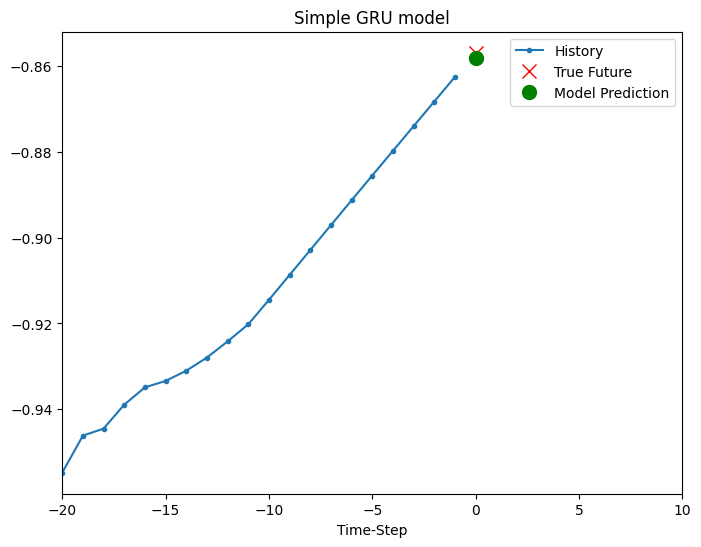

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


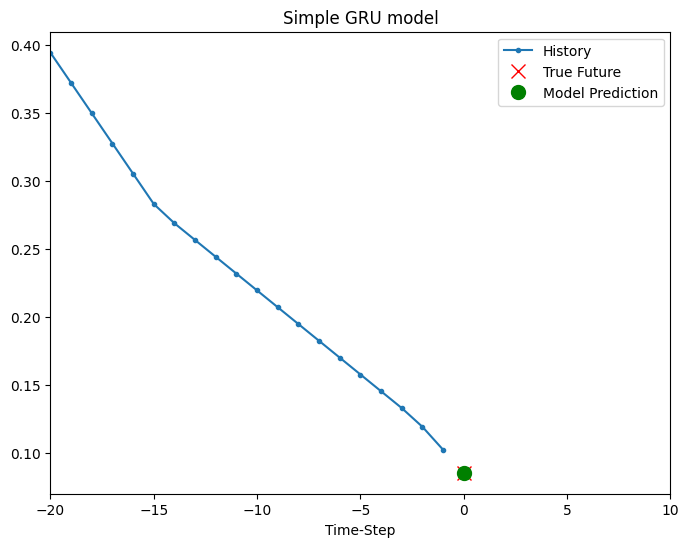

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


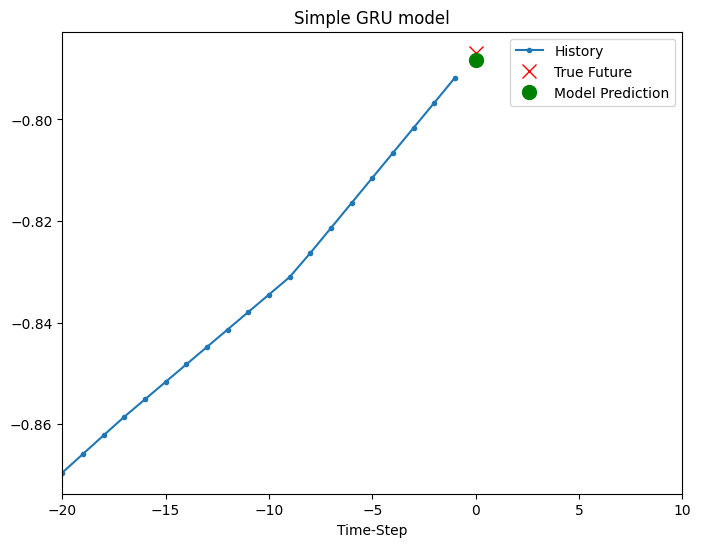

In [51]:
print (x_train_uni.shape)
print (y_train_uni.shape)
x_train_uni.dtype

BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

train_univariate


# defining the model using RU instead of LSTM
simple_GRU_model = tf.keras.models.Sequential([
    tf.keras.layers.GRU(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_GRU_model.compile(optimizer='adam', loss='mae')
simple_GRU_model.summary()
x_train_uni.shape[-2:]

for x, y in val_univariate.take(1):
    print(simple_GRU_model.predict(x).shape)
    print(y.shape)


EVALUATION_INTERVAL = 2000
EPOCHS = 10

simple_GRU_model.fit(train_univariate, 
                      epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, 
                      validation_steps=50)

for x, y in val_univariate.take(3):
    plot = show_plot([x[0].numpy(), y[0].numpy(), simple_GRU_model.predict(x)[0]], 0, 'Simple GRU model')
    plot.show()

### Multivariate GRU based forecasting - Single Step

C:\Users\kemal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_2 (GRU)                     │ (None, 32)             │         3,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,585 (14.00 KB)

 Trainable params: 3,585 (14.00 KB)

 Non-trainable params: 0 (0.00 B)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step  
(256, 1)

 Number of traing data points
64260

 Number of test data points
7140
Epoch 1/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - loss: 0.0881 - val_loss: 0.0246
Epoch 2/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - loss: 0.0261 - val_loss: 0.0228
Epoch 3/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - loss: 0.0226 - val_loss: 0.0178
Epoch 4/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - loss: 0.0203 - val_loss: 0.0166
Epoch 5/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - loss: 0.0188 - val_loss: 0.0161
Epoch 6/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - loss: 0.0178 - val_loss: 0.0148
Epoch 7/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - loss: 0.0171 - val_loss: 0.0140
Epoch 8/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - loss: 0.0166 - val_loss: 0.0154
Epoch 9/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - loss: 0.0162 - val_loss: 0.0136
Epoch 10/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - loss: 0.0158 - val_los

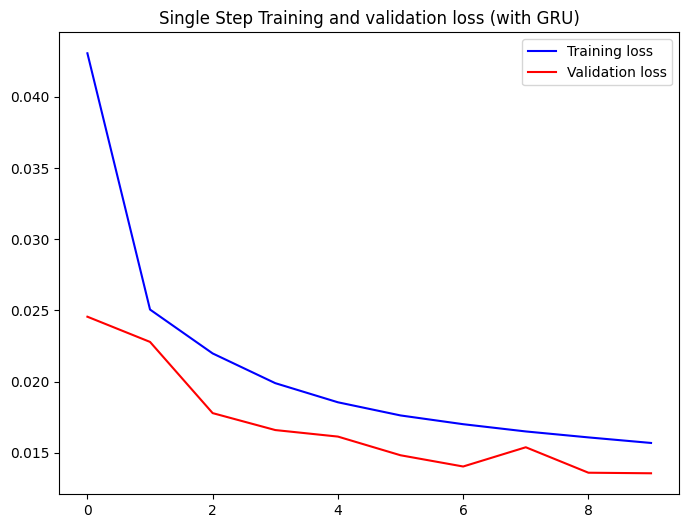

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


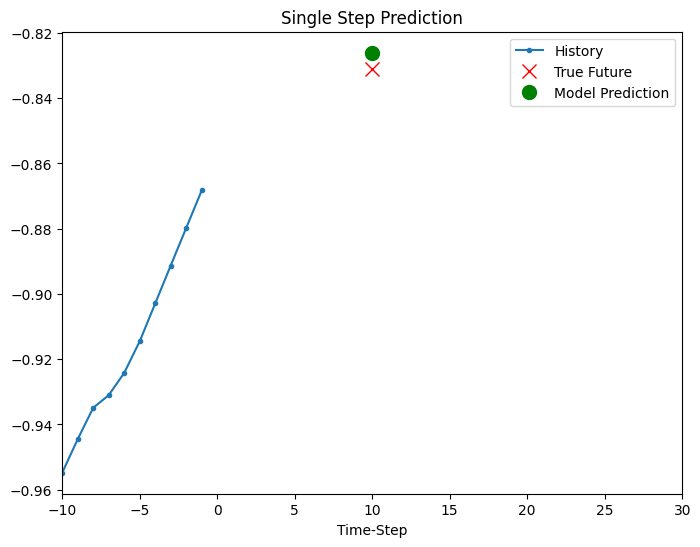

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


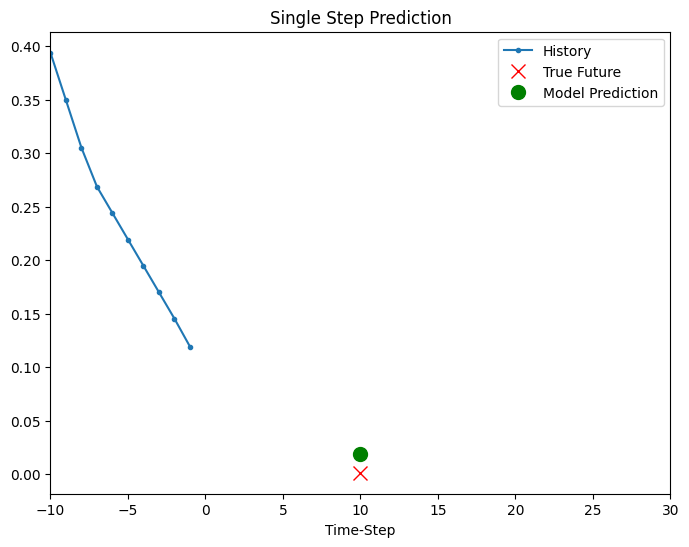

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


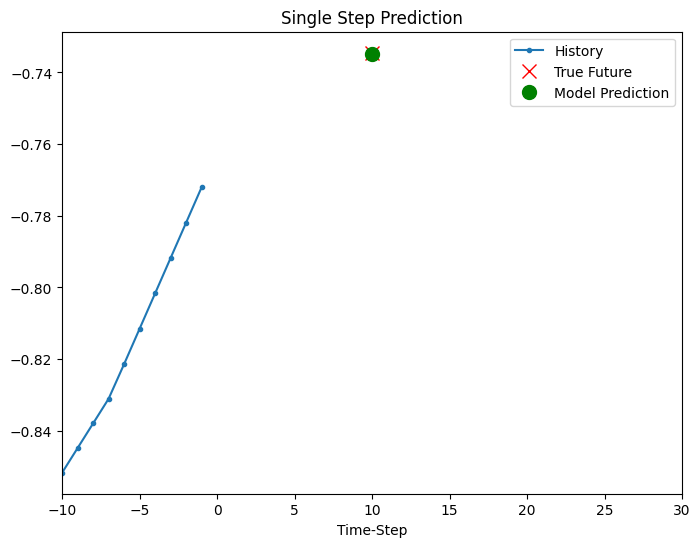

In [56]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

single_step_model_GRU = tf.keras.models.Sequential()
single_step_model_GRU.add(tf.keras.layers.GRU(32, input_shape=x_train_single.shape[-2:]))
single_step_model_GRU.add(tf.keras.layers.Dense(1))

single_step_model_GRU.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')
single_step_model_GRU.summary()
x_train_single.shape[-2:]

for x, y in val_data_single.take(1):
    print(single_step_model_GRU.predict(x).shape)
print ('\n Number of traing data points')
print (x_train_single.shape[0])
print ('\n Number of test data points')
print (x_val_single.shape[0])


single_step_history_GRU = single_step_model_GRU.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=50)

def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()
    plt.show()

plot_train_history(single_step_history_GRU,'Single Step Training and validation loss (with GRU)')

for x, y in val_data_single.take(3):
    plot = show_plot([x[0][:, 0].numpy(), y[0].numpy(),
                    single_step_model_GRU.predict(x)[0]], future_target,
                   'Single Step Prediction')
    plot.show()

### Multivariate GRU - Multiple Steps

Single window of past history : (20, 3)

Target window to predict : (10,)

Number of traing data points: 60885

Number of test data points: 6765


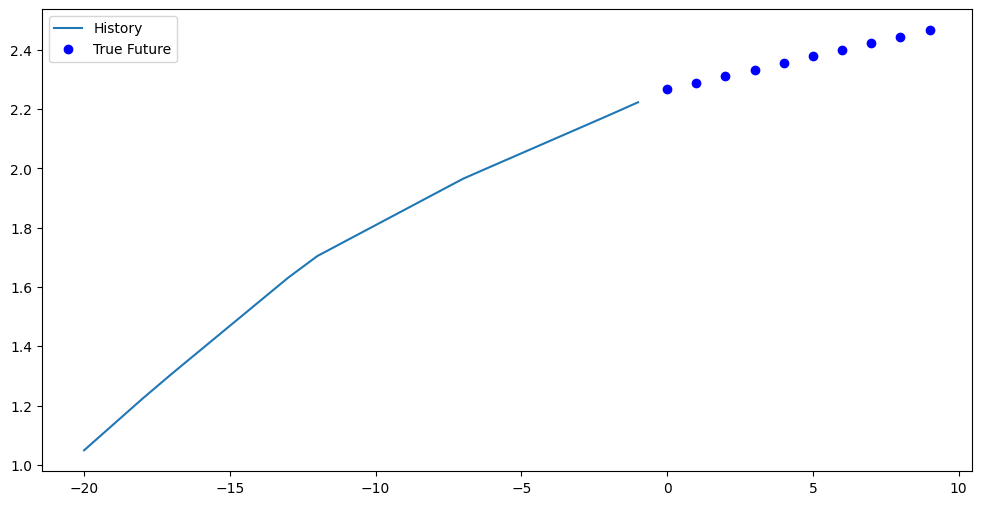

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_3 (GRU)                     │ (None, 20, 32)         │         3,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_4 (GRU)                     │ (None, 16)             │         2,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 10)             │           170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,122 (23.91 KB)

 Trainable params: 6,122 (23.91 KB)

 Non-trainable params: 0 (0.00 B)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
(256, 10)
Epoch 1/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 42s 20ms/step - loss: 0.1394 - val_loss: 0.0313
Epoch 2/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 43s 21ms/step - loss: 0.0291 - val_loss: 0.0262
Epoch 3/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 42s 21ms/step - loss: 0.0250 - val_loss: 0.0221
Epoch 4/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 42s 21ms/step - loss: 0.0226 - val_loss: 0.0180
Epoch 5/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 36s 18ms/step - loss: 0.0209 - val_loss: 0.0197
Epoch 6/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 36s 18ms/step - loss: 0.0197 - val_loss: 0.0166
Epoch 7/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 36s 18ms/step - loss: 0.0186 - val_loss: 0.0160
Epoch 8/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 41s 21ms/step - loss: 0.0178 - val_loss: 0.0151
Epoch 9/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 43s 22ms/step - loss: 0.0171 - val_loss: 0.0143
Epoch 10/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 44s 22ms/step - loss: 0.0166 - val_loss: 0.0164


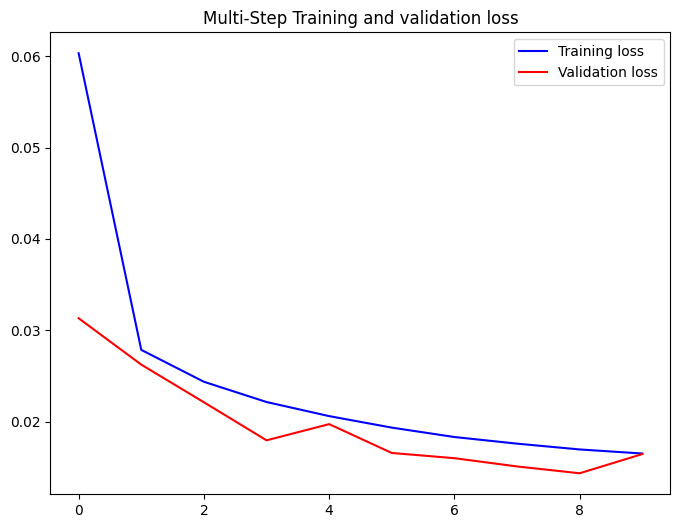

In [81]:
past_history = 40
future_target = 10
STEP =2
x_train_multi, y_train_multi = multivariate_data(dataset, dfInfected_data, 0, TRAIN_SPLIT, 
                                                    past_history, future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dfInfected_data, TRAIN_SPLIT, dataset.shape[1], 
                                                past_history, future_target, STEP)
print ('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('\nTarget window to predict : {}'.format(y_train_multi[0].shape))
print ('\nNumber of traing data points: {}'.format(x_train_multi.shape[0]))
print ('\nNumber of test data points: {}'.format(x_val_multi.shape[0]))

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(12, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)
    plt.plot(num_in, np.array(history[:, 0]), label='History')
    plt.plot(np.arange(num_out), np.array(true_future), 'bo', label='True Future')
    if prediction.any():
        plt.plot(np.arange(num_out), np.array(prediction), 'ro', label='Predicted Future')
    plt.legend(loc='upper left')
    plt.show()

for x, y in train_data_multi.take(1):
    multi_step_plot(x[0], y[0], np.array([0]))

multi_step_model_GRU = tf.keras.models.Sequential()
multi_step_model_GRU.add(tf.keras.layers.GRU(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model_GRU.add(tf.keras.layers.GRU(16, activation='relu'))
multi_step_model_GRU.add(tf.keras.layers.Dense(future_target))

multi_step_model_GRU.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')
multi_step_model_GRU.summary()
x_train_multi.shape[-2:]

for x, y in val_data_multi.take(1):
    print (multi_step_model.predict(x).shape)

multi_step_history_GRU = multi_step_model_GRU.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

plot_train_history(multi_step_history_GRU, 'Multi-Step Training and validation loss')

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


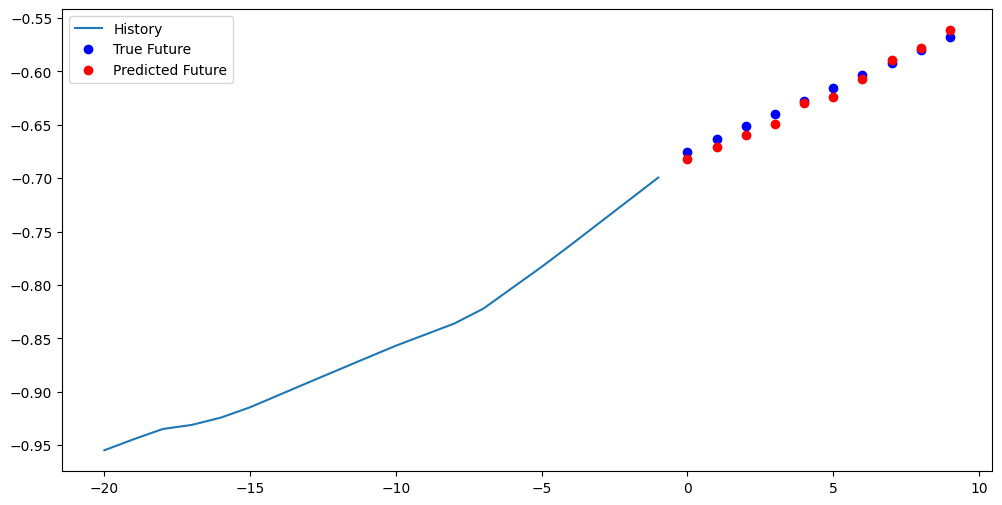

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


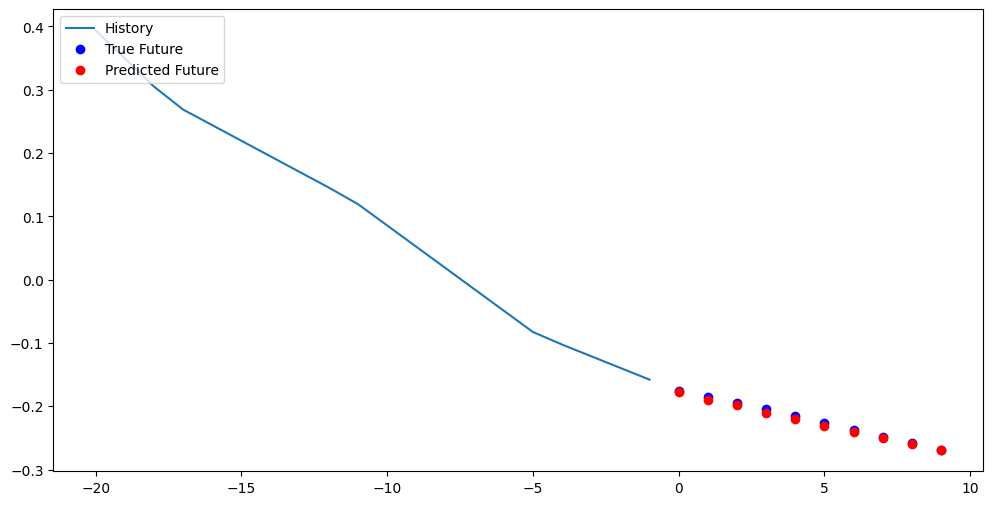

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


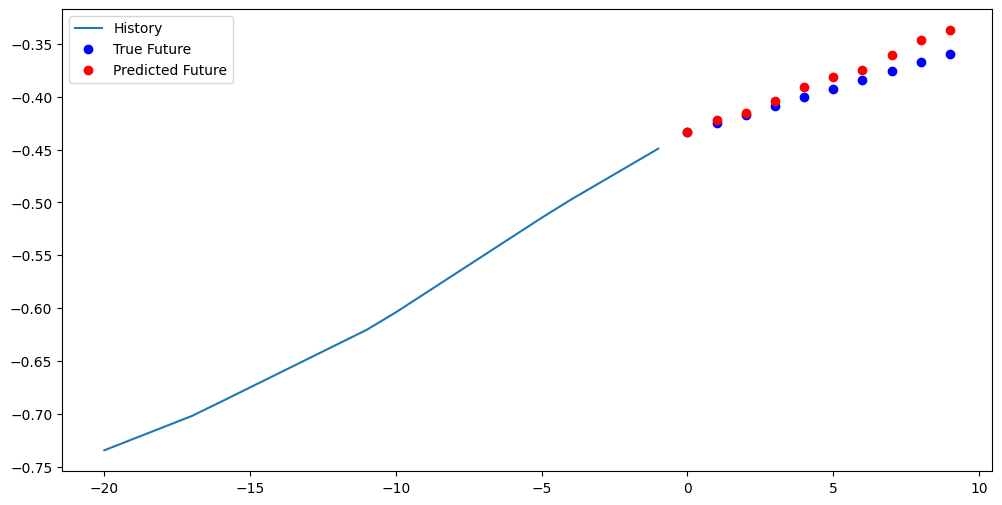

In [82]:
for x, y in val_data_multi.take(3):
    multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])